In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dff = pd.read_csv('/content/drive/MyDrive/busybee/one_year_occupancy.txt', delimiter = "\t")

In [ ]:
df_room1=dff[dff['area_id'] == 'f5017bd4-085c-4efb-a38e-389f4ee42d82']

In [ ]:
df_room1.shape

(278015, 4)

In [ ]:
df=df_room1

In [ ]:
import datetime as dt

df['timestamp'] = pd.to_datetime(df['timestamp'])
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["second"] = df["timestamp"].dt.second
df['weekday'] = df[['timestamp']].apply(lambda x: dt.datetime.strftime(x['timestamp'], '%A'), axis=1)

In [ ]:
df_room1.head()
df_room1.drop('area_id', axis=1, inplace=True)
df_room1.drop('year', axis=1, inplace=True)
df_room1.drop('month', axis=1, inplace=True)
df_room1.drop('day', axis=1, inplace=True)
df_room1.drop('hour', axis=1, inplace=True)
df_room1.drop('minute', axis=1, inplace=True)
df_room1.drop('second', axis=1, inplace=True)
df_room1.drop('weekday', axis=1, inplace=True)

In [ ]:
df_room1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278015 entries, 0 to 380686
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         278015 non-null  int64         
 1   occupancy  278015 non-null  int64         
 2   timestamp  278015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 8.5 MB


In [ ]:
indexedDataset = df_room1.set_index(['timestamp'])

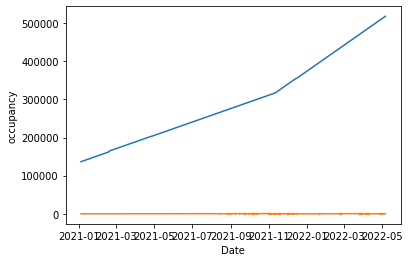

In [ ]:
## plot graph
plt.xlabel('Date')
plt.ylabel('occupancy')
plt.plot(indexedDataset)

In [ ]:
def show_graph(train, test=None, pred=None, title=None):
    
    fig = plt.figure(figsize=(20, 5))

    # entire data
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Price')
    ax1.plot(train.index, train['occupancy'], color='green', label='Train price')
    if test is not None:
        ax1.plot(test.index, test['occupancy'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax1.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted occupancy')
            ax1.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax1.plot(pred.index, pred['Price'], color='blue', label='Predicted occupancy')
    ax1.legend()
    if title is not None:
        plt.title(title + ' (Entire)')
    plt.grid(True)

    # zoom data
    period=50
    period=int(0.2*len(train))
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Dates')
    ax2.set_ylabel('occupancy')
    ax2.plot(train.index[-period:], train['occupancy'].tail(period), color='green', label='Train price')
    if test is not None:
        ax2.plot(test.index, test['occupancy'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax2.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted occupancy')
            ax2.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax2.plot(pred.index, pred['occupancy'], color='blue', label='Predicted occupancy')
    ax2.legend()
    if title is not None:
        plt.title(title + ' (Recent ' + str(period) + ')')
    plt.grid(True)

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

def calculate_accuracy(forecast, actual, algorithm):
    mse  = round(mean_squared_error(actual, forecast),4)
    mae  = round(mean_absolute_error(actual, forecast),4)
    rmse = round(sqrt(mean_squared_error(actual, forecast)),4)
    return ({'algorithm':algorithm, 'mse':mse, 'mae':mae, 'rmse': rmse})

In [ ]:
model_name='Facebook Prophet'

In [ ]:
from fbprophet import Prophet
def predict_prophet(train,period):
    # create model
    prop = Prophet(growth='logistic',
                    n_changepoints=40,
                    changepoint_range=1,
                    changepoint_prior_scale=0.5,
                    weekly_seasonality=False,
                    yearly_seasonality=False
                  )
    # prepare training dataset
    ph_df_train = pd.DataFrame({'y':train['occupancy'].values, 'ds':train.index})
    ph_df_train['cap'] = 100
    ph_df_train['floor'] = 0
    print("prepared training dataset")
    prop.fit(ph_df_train)
    print("training complete")
    # create future dates
    future_prices = prop.make_future_dataframe(periods=period, freq = 'd')
    future_prices['cap'] = 100
    future_prices['floor'] = 0

    # predict prices
    forecast = prop.predict(future_prices)
    predicted=forecast[-period:]
    print("predicting")
    return predicted

In [ ]:
#exp1
#indexedDataset = indexedDataset['2021-10-01':'2022-05-01']

In [ ]:
#exp2
indexedDataset = indexedDataset['2022-1-01':'2022-05-01']

In [ ]:
split = int(0.99*len(indexedDataset))
train_data, test_data = indexedDataset[0:split], indexedDataset[split:]


In [ ]:
train_data.shape 

(68677, 2)

In [ ]:
test_data.shape

(694, 2)

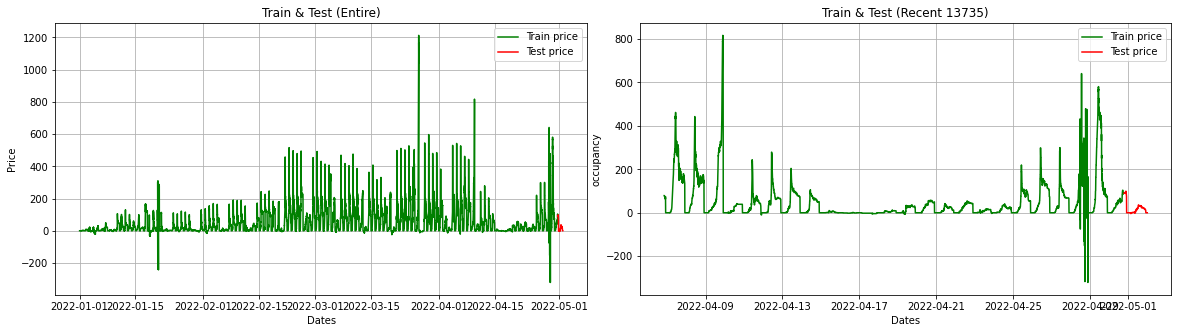

In [ ]:
show_graph(train_data,test_data,title='Train & Test')

In [ ]:
# predict test period
predictions = predict_prophet(train_data,len(test_data))
predictions.index = test_data.index

prepared training dataset
training complete
predicting


In [ ]:
acc_sum=[]

In [ ]:
# calculate performance metrics
acc = calculate_accuracy(predictions['yhat'], test_data['occupancy'], model_name)
print(acc)
acc_sum.append(acc)

{'algorithm': 'Facebook Prophet', 'mse': 13093.1176, 'mae': 111.1127, 'rmse': 114.4252}


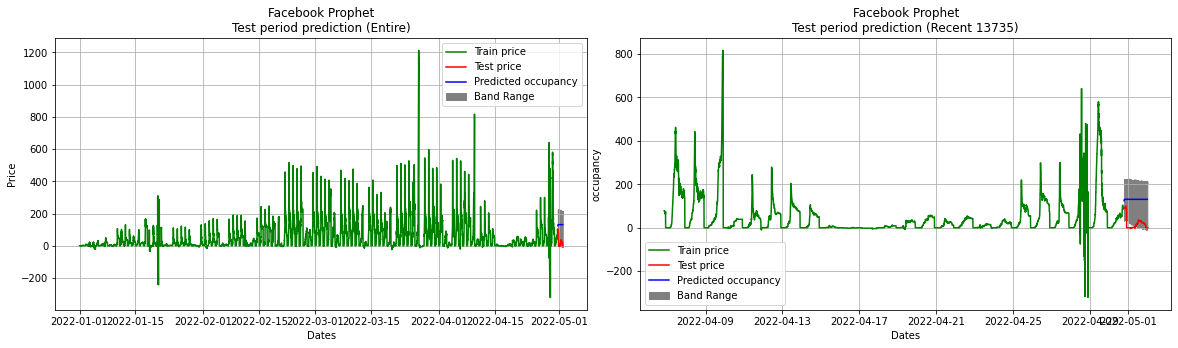

In [ ]:
# show result
show_graph(train_data, test_data, predictions, title=model_name + '\nTest period prediction')

In [ ]:
# predict future period
forecast_out = 34
future_dates = make_future_dates(indexedDataset.index[-1], forecast_out)
predictions = predict_prophet(indexedDataset,len(future_dates))
predictions.index = future_dates

prepared training dataset
training complete
predicting


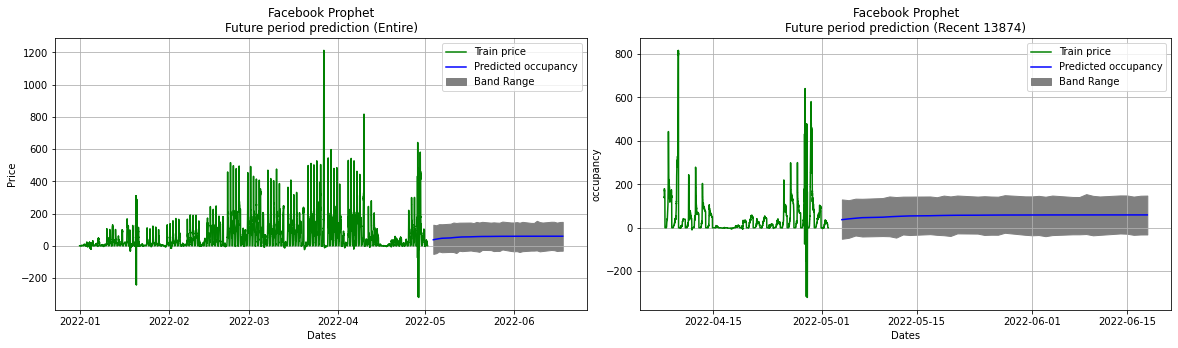

In [ ]:
# show result
show_graph(indexedDataset,None,predictions,title=model_name+'\nFuture period prediction')